<a href="https://colab.research.google.com/github/Vinayak-Sharma12/LangGraph/blob/main/6_ReAct_Agent_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ReAct- ReAct is basically an architecture in which connect tool reponse back to llm**

In [1]:
!pip install -q langgraph langchain_groq langchain langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 17.3 MB/s eta 0:00:00


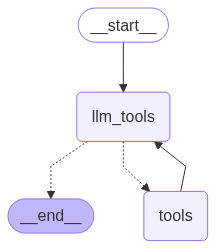

In [26]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

## **CREATE STATE**

In [3]:
from typing import TypedDict,Annotated
from langgraph.graph import add_messages

In [4]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

## **CREATE TOOLS**

In [5]:
def add(a:int,b:int)->int:
  """take two numbers and returns its addition"""
  return a+b

In [6]:
def sub(a:int,b:int)->int:
  """take two numbers and returns its subtraction"""
  return a-b

### **BIND TOOL WITH LLM**

In [15]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='llama-3.1-8b-instant',api_key='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')

In [18]:
llm_with_tools=llm.bind_tools([add,sub])

## **CREATE NODE**

In [30]:
def llm_tools(state:State):
  return {'messages':llm_with_tools.invoke(state['messages'])}

## **GRAPH**

In [31]:
from langgraph.graph import START,END,StateGraph
from langgraph.prebuilt import ToolNode,tools_condition

#Create State
builder=StateGraph(State)

#Add Nodes
builder.add_node("llm_tools",llm_tools)
builder.add_node("tools",ToolNode([add,sub]))

#Add Edges
builder.add_edge(START,"llm_tools")
builder.add_conditional_edges("llm_tools",tools_condition)
builder.add_edge("tools","llm_tools")

#Compile
graph=builder.compile()



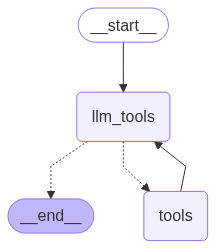

In [32]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
# Import HumanMessage
from langchain_core.messages import HumanMessage
graph.invoke({'messages':HumanMessage(content="Add 6 plus 9 then subtract 7 then add 4 then subtract 2 then add 10 and subtract 5 ")})

{'messages': [HumanMessage(content='Add 6 plus 9 then subtract 7 then add 4 then subtract 2 then add 10 and subtract 5 ', additional_kwargs={}, response_metadata={}, id='f85b968b-4a5e-4bd1-9c56-aa4f5ed382aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qm3z', 'function': {'arguments': '{"a":6,"b":9}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_nx7m', 'function': {'arguments': '{"a":6,"b":7}', 'name': 'sub'}, 'type': 'function'}, {'id': 'call_9gfr', 'function': {'arguments': '{"a":6,"b":4}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_r2y7', 'function': {'arguments': '{"a":6,"b":2}', 'name': 'sub'}, 'type': 'function'}, {'id': 'call_7v47', 'function': {'arguments': '{"a":6,"b":10}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_912a', 'function': {'arguments': '{"a":6,"b":5}', 'name': 'sub'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 306, 'total_tokens': 409, 'completion_time': 0.1538

In [36]:
messages=[HumanMessage(content="Add 6 plus 9 then subtract 7 then add 4 then subtract 2 then add 10 and subtract 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 6 plus 9 then subtract 7 then add 4 then subtract 2 then add 10 and subtract 5
================================== Ai Message ==================================
Tool Calls:
  add (call_bf6p)
 Call ID: call_bf6p
  Args:
    a: 6
    b: 9
  sub (call_j8am)
 Call ID: call_j8am
  Args:
    a: 15
    b: 7
  add (call_1qk0)
 Call ID: call_1qk0
  Args:
    a: 8
    b: 4
  sub (call_223a)
 Call ID: call_223a
  Args:
    a: 12
    b: 2
  add (call_nrna)
 Call ID: call_nrna
  Args:
    a: 10
    b: 10
  sub (call_6qq8)
 Call ID: call_6qq8
  Args:
    a: 20
    b: 5
================================= Tool Message =================================
Name: add

15
================================= Tool Message =================================
Name: sub

8
================================= Tool Message =================================
Name: add

12
================================= Tool Message ======================